In [85]:
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split

from tqdm import tqdm

from two_spirals_utils import spiral_dataset, SpiralClassifier
from utils.utils import get_grid_predictions, create_contour_plot

# Spiral Dataset

We defined a dataset of two interlocking spirals in the file `SpiralDataset.py`, where each spiral represents one of two classes.

Let's visualise this dataset to get a better idea of the classification problem we're trying to solve.

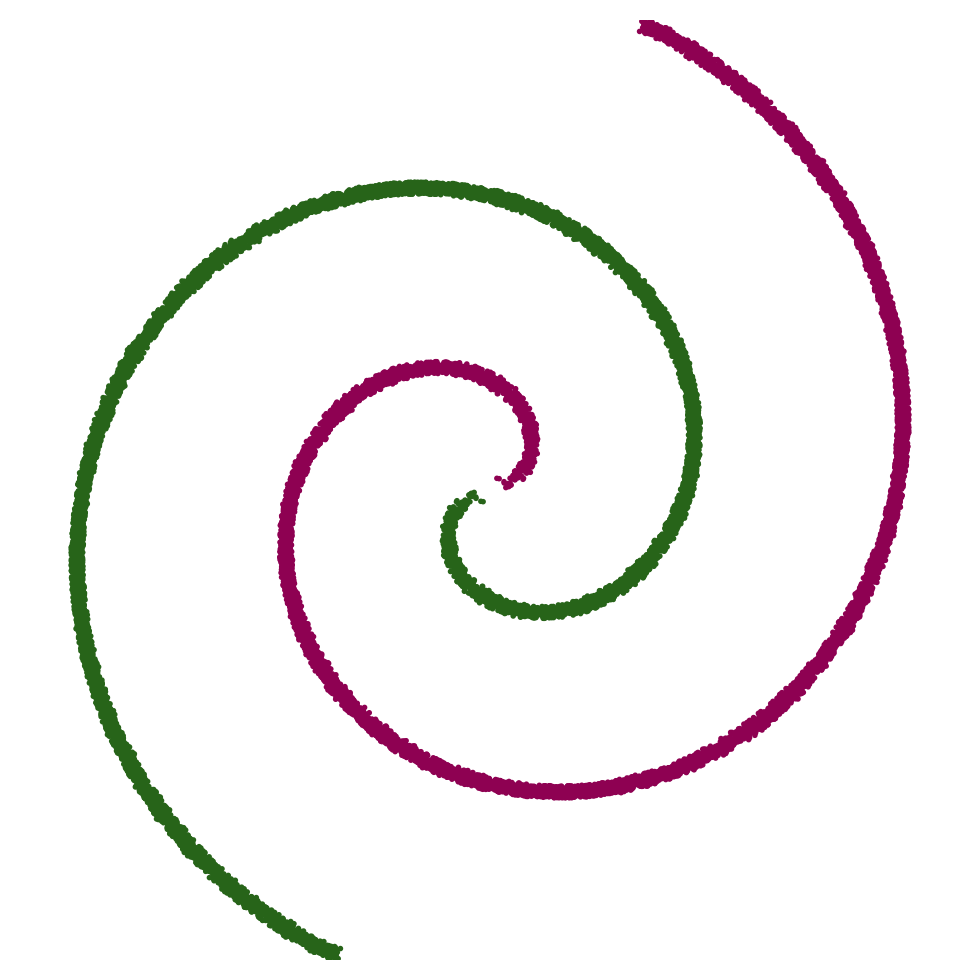

In [86]:
X, Y = spiral_dataset(n_samples=20_000, noise=3, n_rotations=1.2)

# colormap = colors.ListedColormap(["darkmagenta", "lightseagreen"])
colormap = plt.get_cmap("PiYG")

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap=colormap)
plt.xlim(X.T.min(), X.T.max())
plt.ylim(X.T.min(), X.T.max())
plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.tight_layout()

# Create Dataset and Train/Eval Split

In [87]:
n_samples   = 20_000
noise       = 3
n_rotations = 1.2
batch_size  = 512
train_split = 0.8  # We use 80% of the data for training, 20% for evaluation

# Generate spiral dataset
dataset = TensorDataset(*spiral_dataset(n_samples, noise, n_rotations))
    
# Calculate the sizes of the train and eval dataset
train_size = int(train_split * len(dataset))
eval_size  = len(dataset) - train_size

# Split the dataset
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(eval_dataset,  batch_size=batch_size, shuffle=False)

# Train Spiral Classifier

In [88]:
n_epochs      = 60
lr            = 1e-4
loss_function = nn.CrossEntropyLoss()
model         = SpiralClassifier(2, 2, n_inner_layers=4, width=128)
optimizer     = torch.optim.Adam(model.parameters(), lr=lr)

# Initialise lists used for tracking loss and accuracy
train_losses     = np.empty(n_epochs)
eval_losses      = np.empty(n_epochs)
train_accuracies = np.empty(n_epochs)
eval_accuracies  = np.empty(n_epochs)

In [89]:
# # Initialize tqdm progress bar for epochs
# epoch_bar = tqdm(range(n_epochs), desc="Epoch")

# for epoch in epoch_bar:
#     # Training
#     model.train()
#     train_loss = 0
#     train_accuracy = 0
#     train_batches = 0
#     for x, y in train_loader:
#         # Forward pass
#         preds = model(x)
#         loss = loss_function(preds, y)
#         train_loss += loss.item()

#         # Calculate batch accuracy
#         accuracy = (preds.argmax(1) == y).type(torch.float).mean().item()
#         train_accuracy += accuracy

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_batches += 1

#     avg_train_loss     = train_loss     / train_batches
#     avg_train_accuracy = train_accuracy / train_batches

#     # Evaluation
#     model.eval()
#     eval_loss     = 0
#     eval_accuracy = 0
#     eval_batches  = 0
#     with torch.no_grad():
#         for x, y in eval_loader:
#             preds = model(x)

#             # Calculate batch loss
#             loss = loss_function(preds, y)
#             eval_loss += loss.item()

#             # Calculate batch accuracy
#             accuracy = (preds.argmax(1) == y).type(torch.float).mean().item()
#             eval_accuracy += accuracy

#             eval_batches += 1

#     avg_eval_loss     = eval_loss     / eval_batches
#     avg_eval_accuracy = eval_accuracy / eval_batches

#     # Record training history
#     train_losses[epoch]     = avg_train_loss
#     eval_losses[epoch]      = avg_eval_loss
#     train_accuracies[epoch] = avg_train_accuracy
#     eval_accuracies[epoch]  = avg_eval_accuracy

#     # Create contour plot of current decision boundary
#     # [COMMENTED OUT TO INCREASE TRAINING SPEED]
#     xs, ys, grid_preds = get_grid_predictions(model, probs=True)
#     dir_path = Path(f"../figures/spiral_boundaries_noise_{noise}")
#     dir_path.mkdir(exist_ok=True)  # Create directory if it doesn't exist
#     file_path = str(dir_path / f"epoch_{epoch}.png")
#     create_contour_plot(xs, ys, grid_preds, dataset=dataset, file_path=file_path, epoch=epoch, colormap=colormap)

#     # Update tqdm description with current metrics
#     epoch_bar.set_description(f"Train loss: {avg_train_loss:.3f} - Eval loss: {avg_eval_loss:.3f} - Train acc: {100*avg_train_accuracy:.2f}% - Eval acc: {100*avg_eval_accuracy:.2f}%")

# torch.save(model.state_dict(), "../models/spirals/classifier_two_spirals_new.pt")

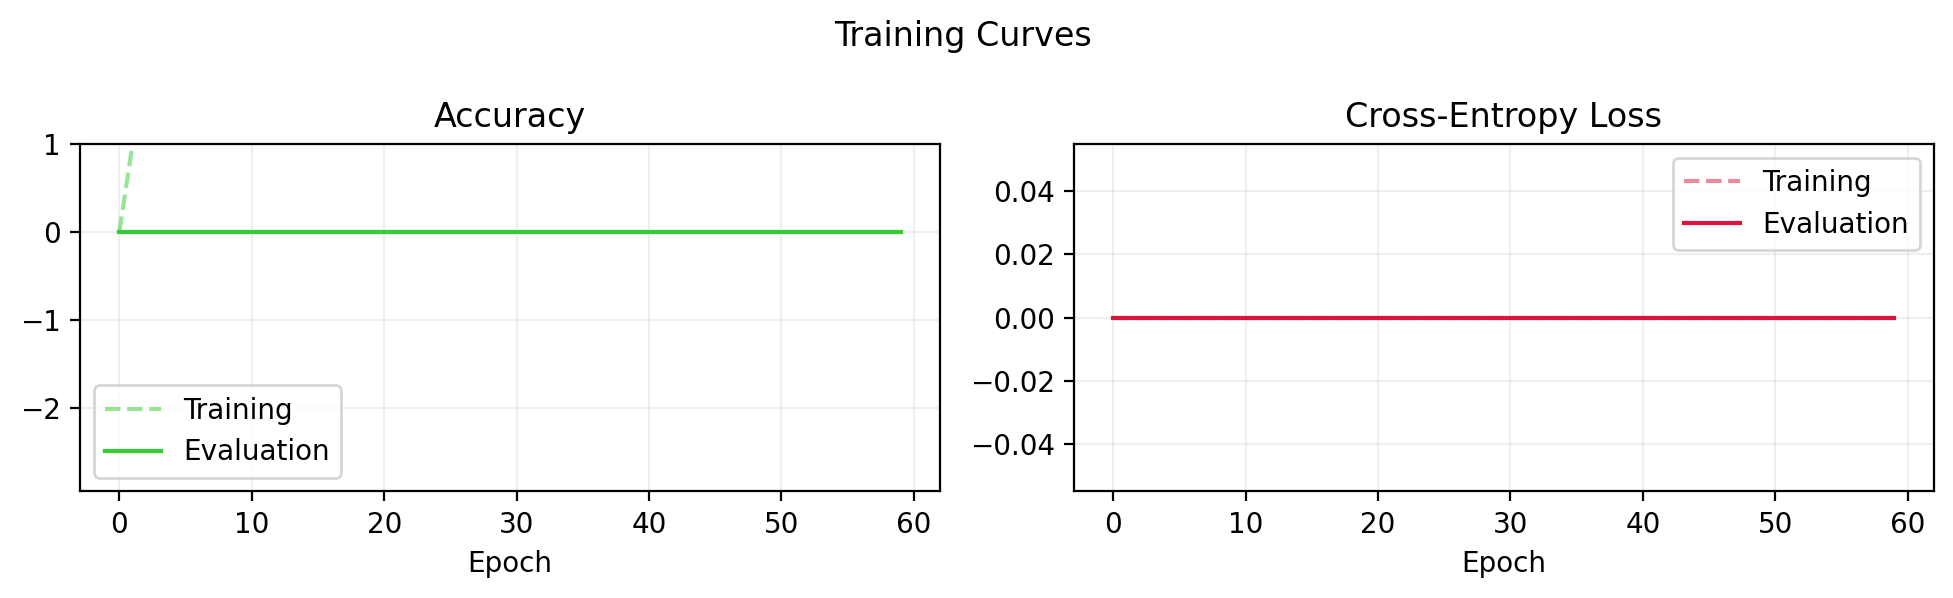

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=200)

plt.suptitle("Training Curves")
ax[0].set_title("Accuracy")
ax[0].plot(train_accuracies, c="limegreen", label="Training", ls="--", alpha=0.5)
ax[0].plot(eval_accuracies,  c="limegreen", label="Evaluation")
ax[0].set_ylim(None, 1)
ax[0].set_xlabel("Epoch")
ax[0].grid(alpha=0.2)
ax[0].legend()

ax[1].plot(train_losses, c="crimson", label="Training", ls="--", alpha=0.5)
ax[1].plot(eval_losses,  c="crimson", label="Evaluation")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Cross-Entropy Loss")
ax[1].grid(alpha=0.2)
ax[1].legend()

plt.tight_layout()

# Visualise decision boundary of the trained classifier 

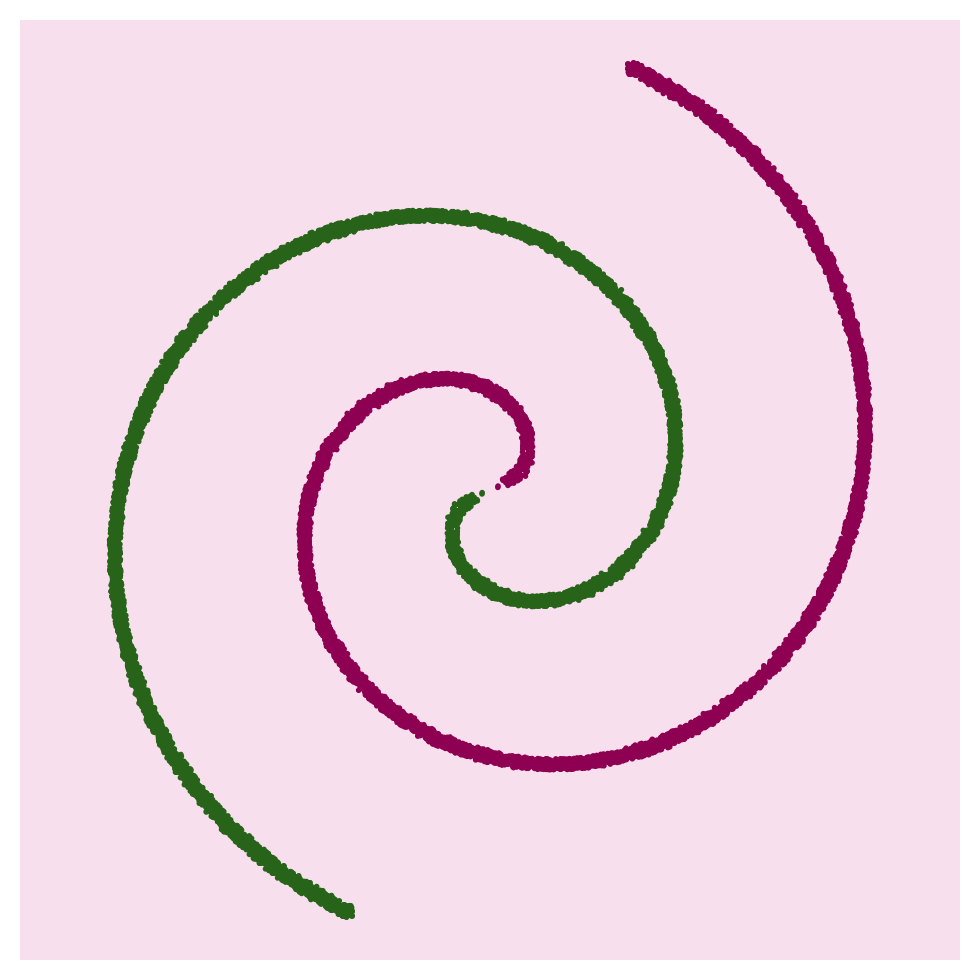

In [91]:
xs, ys, grid_preds = get_grid_predictions(model)
create_contour_plot(xs, ys, grid_preds, dataset=dataset, colormap=colormap)

# Train $\mathcal{M}$-Flow model on the "two spirals" dataset

In [92]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms, training
from manifold_flow.architectures.vector_transforms import create_vector_transform

import logging

# Set up Python's logging system to show INFO logs for M-Flow code
logging.basicConfig(
    format="%(asctime)-5.5s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Ensure that logging output of all other modules (e.g. matplotlib) is shown
# only if it is at least a WARNING, not just an INFO.
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [93]:
n_samples   = 20_000
noise       = 3
n_rotations = 1.2

# Generate spiral dataset
dataset = TensorDataset(spiral_dataset(n_samples, noise, n_rotations)[0])

In [94]:
# QUESTIONS:
# ??? What inner_transform and outer_transform should we use ???
# ??? What do all these training parameters in the next cell and in the trainer
#     objects mean, and how should they be set ???

# Define M-Flow model
params = {
    "n_rotations"        : n_rotations,
    "batch_size"         : 512,
    "n_flow_steps"       : 16,   # Depth (#layers)  of the "outer transform"
    "hidden_features"    : 100,  # Width (#neurons) of the "outer transform"
    "n_transform_blocks" : 2     # ???
}
mflow = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(
        dim                  = 2,
        flow_steps           = params["n_flow_steps"],
        hidden_features      = params["hidden_features"],
        num_transform_blocks = params["n_transform_blocks"]
    )
)

16:40 Model has 0.7 M parameters (0.7 M trainable) with an estimated size of 2.7 MB
16:40   Outer transform: 0.7 M parameters
16:40   Inner transform: 0.0 M parameters


The cell below will train the $\mathcal{M}$-Flow model on the two spirals dataset and write a plot of samples from the learned distribution after each training epoch to `figures/spiral_mflow/epoch_*.png`. Set the argument `write_per_epoch_plots` to `False` if you wish to turn off this plotting.

In [95]:
train    = True  #  Switch between training and loading the last trained model
n_epochs = 35

if train:
    trainer     = training.ForwardTrainer(mflow)
    metatrainer = training.AlternatingTrainer(mflow, trainer, trainer)
    losses_train, losses_eval = metatrainer.train(
        dataset,
        loss_functions=[training.losses.mse, training.losses.nll],
        loss_function_trainers=[0, 1],
        loss_labels=["MSE", "NLL"],
        loss_weights=[100., 0],
        epochs=n_epochs,
        batch_sizes=params["batch_size"],
        parameters=[mflow.parameters(), mflow.inner_transform.parameters()],
        verbose="all",
        trainer_kwargs=[
            {"forward_kwargs": {"mode": "projection"}},
            {"forward_kwargs": {"mode": "pie"}}
        ],
        write_per_epoch_plots=True,  # Writes sample plot to disk after each epoch
        params=params
    )
    torch.save(mflow.state_dict(), "../models/spirals/mflow_two_spirals.pt")
else:
    mflow.load_state_dict(torch.load("../models/spirals/mflow_two_spirals.pt"))

16:40 Training on CPU with single precision
16:40 Training on CPU with single precision
16:41 Epoch   1: train loss 16.05950 (MSE:  0.161, NLL: 5751.860)
16:41            val. loss  12.53647 (MSE:  0.125, NLL: 5702.912)
16:41 Epoch   2: train loss 11.59955 (MSE:  0.116, NLL: 5862.098)
16:41            val. loss  10.94216 (MSE:  0.109, NLL: 5833.088)
16:41 Epoch   3: train loss  9.25846 (MSE:  0.093, NLL: 4356.556)
16:41            val. loss   8.44493 (MSE:  0.084, NLL: 4326.342)
16:41 Epoch   4: train loss 10.54806 (MSE:  0.105, NLL: 4068.664)
16:41            val. loss   6.98993 (MSE:  0.070, NLL: 4053.976)
16:42 Epoch   5: train loss  8.06613 (MSE:  0.081, NLL: 4946.155)
16:42            val. loss   9.57186 (MSE:  0.096, NLL: 4870.519)
16:42 Epoch   6: train loss  7.35276 (MSE:  0.074, NLL: 3799.052)
16:42            val. loss   6.38885 (MSE:  0.064, NLL: 3763.344)
16:42 Epoch   7: train loss  9.39270 (MSE:  0.094, NLL: 2993.384)
16:42            val. loss   9.26761 (MSE:  0.093, NLL

<Figure size 640x480 with 0 Axes>

Below we visualise the training and evaluation losses from the $\mathcal{M}$-Flow training run.

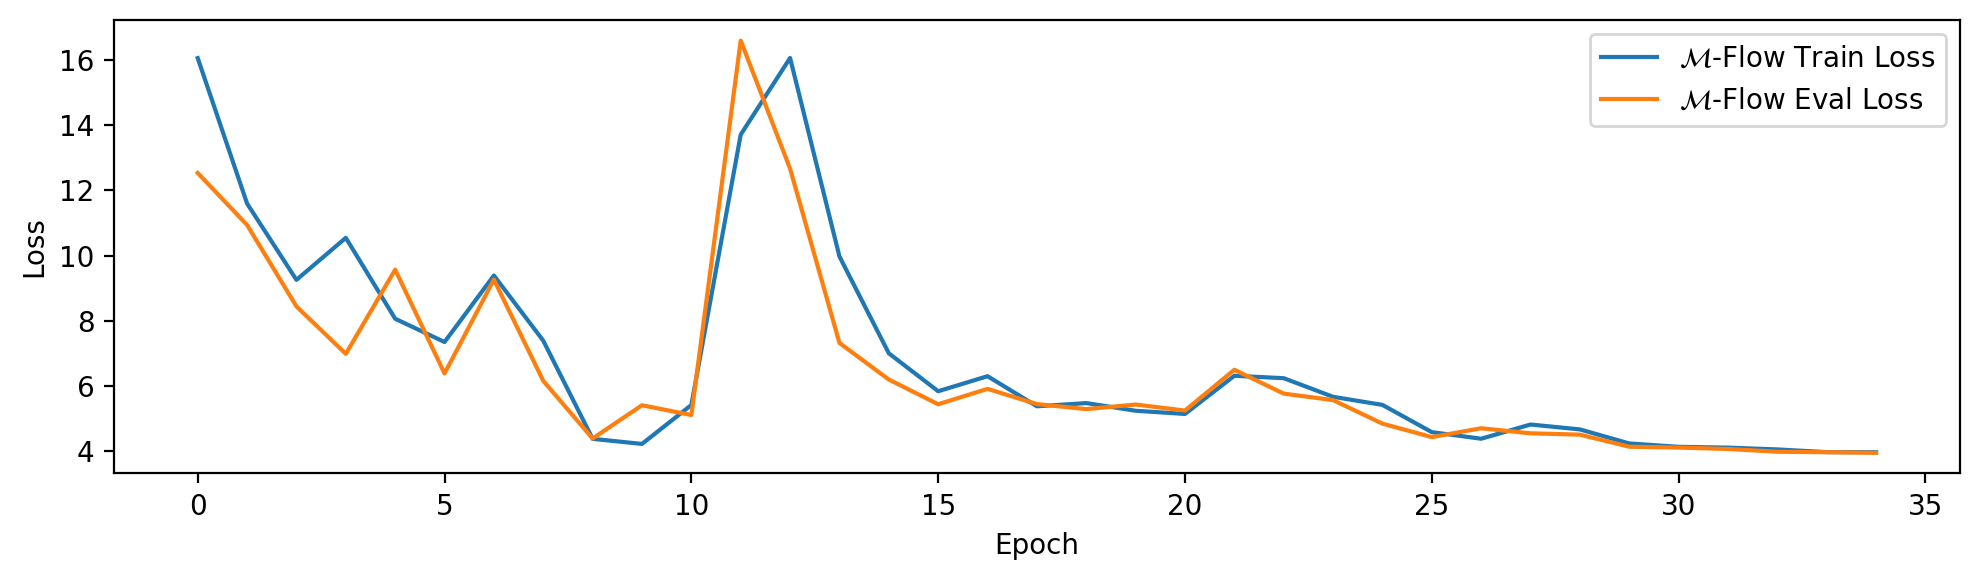

In [96]:
plt.figure(figsize=(10, 3), dpi=200)
plt.plot(losses_train, label=r"$\mathcal{M}$-Flow Train Loss")
plt.plot(losses_eval,  label=r"$\mathcal{M}$-Flow Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()

# Sample points from the trained $\mathcal{M}$-Flow model
After training the $\mathcal{M}$-Flow on the _Two Spirals_ dataset we now sample from the learned distribution.

If the distribution was learned successfully, we should see that the generated samples (points in dark magenta) align with the shape of the _Two Spirals_ dataset (points in faint gray).

In [97]:
mflow.eval()
samples = mflow.sample(n=10_000).detach().numpy()

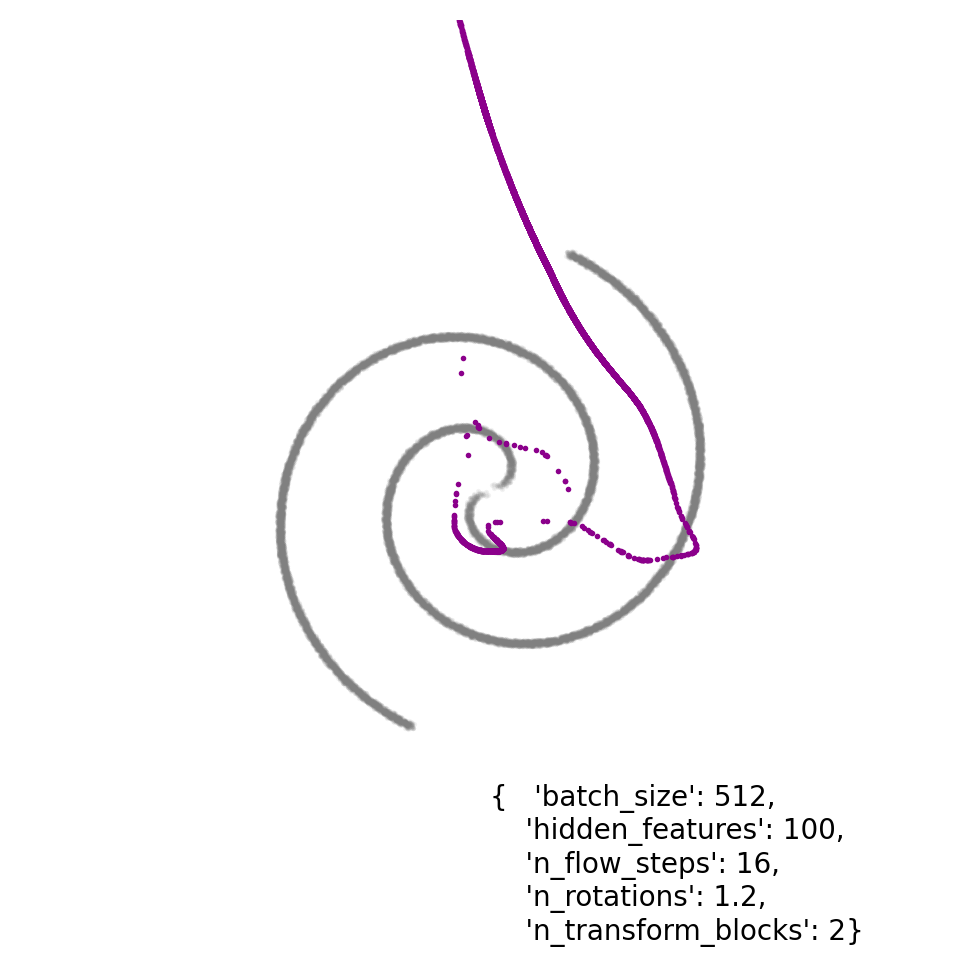

In [98]:
plt.figure(figsize=(5, 5), dpi=200)
X = dataset.tensors[0]
plt.scatter(X[:, 0], X[:, 1], s=0.8, c="gray", alpha=0.1)
plt.scatter(samples[:, 0], samples[:, 1], s=1, c="darkmagenta")
plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.text(0, -2.2, pprint.pformat(params, indent=4))
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.tight_layout()